Comparing the GRB's :

`nbd[2] = [6,15,3235,3244]`

6 = GRB150312403

15 = GRB170130697

In [3]:
import pandas as pd
import numpy as np

In [14]:
# get the ra and dec values of grbs to compare
#light curve dataframe
lcdf = pd.read_csv('gbmdatacleaned.csv', index_col = 0)
grb_index = [6,15,2]
ra = [] #to hold ra values
dec = [] #to hold dec values
for i in grb_index:
    ra.append(lcdf.iloc[i].ra_val)
    dec.append(lcdf.iloc[i].dec_val)

In [16]:
#find the name of the brightest NaI detector
import estimate_source_angles_detectors as esad
b1, b2, b3 = esad.angle_to_grb(ra[0], dec[0],'/Users/dimrisudhanshu/Downloads/current/glg_trigdat_all_bn150312403_v01.fit')
print(b1)
b1, b2, b3 = esad.angle_to_grb(ra[1], dec[1],'/Users/dimrisudhanshu/Downloads/current/glg_trigdat_all_bn170130697_v01.fit')
print(b1)
b1, b2, b3 = esad.angle_to_grb(ra[2], dec[2],'/Users/dimrisudhanshu/Downloads/current/glg_trigdat_all_bn141205018_v01.fit')
print(b1)

n3
n3
n8


In [18]:
from astropy.io import fits

#open the fits file corresponding to the brightest NaI detectors
fitfile1 = fits.open('/Users/dimrisudhanshu/Downloads/current/glg_tte_n3_bn150312403_v01.fit')
fitfile2 = fits.open('/Users/dimrisudhanshu/Downloads/current/glg_tte_n3_bn170130697_v00.fit')
fitfile3 = fits.open('/Users/dimrisudhanshu/Downloads/current/glg_tte_n8_bn141205018_v00.fit')

#convert the EVENTS header into a dataframe
timedf1 = pd.DataFrame(fitfile1[2].data)
timedf2 = pd.DataFrame(fitfile2[2].data)
timedf3 = pd.DataFrame(fitfile3[2].data)

#change the dtype of both the columns
timedf1.PHA = timedf1.PHA.astype('int32')
timedf1.TIME = timedf1.TIME.astype('float')
timedf2.PHA = timedf2.PHA.astype('int32')
timedf2.TIME = timedf2.TIME.astype('float')
timedf3.PHA = timedf3.PHA.astype('int32')
timedf3.TIME = timedf3.TIME.astype('float')

#get trigger time from the fits file
trigtime1 = fitfile1[0].header['TRIGTIME']
trigtime2 = fitfile2[0].header['TRIGTIME']
trigtime3 = fitfile3[0].header['TRIGTIME']

#make a new translated time column
timedf1['TTIME'] = timedf1.TIME - trigtime1
timedf2['TTIME'] = timedf2.TIME - trigtime2
timedf3['TTIME'] = timedf3.TIME - trigtime3

In [19]:
#get the names of the GRB's
grbname1 = fitfile1[0].header['OBJECT']
grbname2 = fitfile2[0].header['OBJECT']
grbname3 = fitfile3[0].header['OBJECT']

def get_t90(grbname):
    '''
    function to get the t90 value of a given grb from the cleaned 
    gbm dataset
    grbname = name of the grb 
    '''
    lcdf = pd.read_csv('gbmdatacleaned.csv', index_col = 0)
    result = lcdf.loc[lcdf.name == grbname] #find the row with name = grbname
    # print(result)
    t90 = result.t90 #this is an object
    return float(t90.iloc[0].strip()) #strip to remove the trailing whitespaces

In [77]:
def getBinSize(t90):
    if t90 >= 2:
        return 1
    else:
        return 0.1

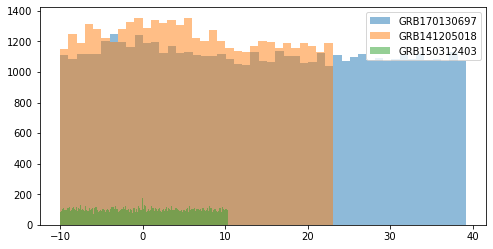

In [89]:
#print the histogram to get the photon counts
import matplotlib.pyplot as plt

t90_1 = get_t90(grbname1)
t90_2 = get_t90(grbname2)
t90_3 = get_t90(grbname3)

plt.figure(figsize = (8,4))
start_1, end_1 = -10, t90_1 + 10
start_2, end_2 = -10, t90_2 + 10
start_3, end_3 = -10, t90_3 + 10

bin_size1 = getBinSize(t90_1)
bin_size2 = getBinSize(t90_2)
bin_size3 = getBinSize(t90_3)


N2 = plt.hist(timedf2.TTIME, bins = int((end_2 - start_2)/bin_size2), range = (start_2, end_2), alpha = 0.5, label = grbname2)
N3 = plt.hist(timedf3.TTIME, bins = int((end_3 - start_3)/bin_size3), range = (start_3, end_3), alpha = 0.5, label = grbname3)
N1 = plt.hist(timedf1.TTIME, bins = int((end_1 - start_1)/bin_size1), range = (start_1, end_1), alpha = 0.5, label = grbname1)

plt.legend(loc = 'upper right')

In [90]:
n2 = N2[0]
n1 = N1[0]
n3 = N3[0]

Now `n1` and `n2` are our two light curves

In [91]:
# length of both time series
print(len(n1), len(n2), len(n3))

203 49 33


211693.0 2762.0


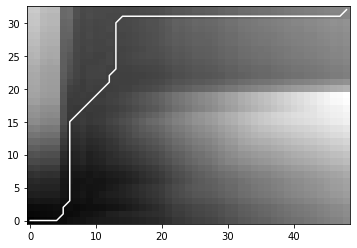

In [92]:
# Applying DTW to these light curves
from dtw import dtw
manhattan_distance = lambda x, y : np.abs(x-y)
d1, cost_matrix, acc_cost_matrix, path = dtw(n1,n3, dist = manhattan_distance)
d2, cost_matrix, acc_cost_matrix, path = dtw(n2,n3, dist = manhattan_distance)
print(d1, d2)

#visualizing the plot
plt.imshow(acc_cost_matrix.T, origin='lower', cmap='gray', interpolation='nearest')
plt.plot(path[0], path[1], 'w')
plt.show()

### TODO
---
1. Light Curve Simulation

In [93]:
from scipy.stats import poisson
import time
import seaborn as sns

In [97]:
simulated_curves = []
for i in range(1000):
    new_curve = []
    for n in n3:
        new_curve.append(poisson.rvs(mu = n, size = 1)[0])
    simulated_curves.append(new_curve)

In [98]:
start_time = time.time()
dtw_list = []
for curve in simulated_curves:
    d, a, b, c = dtw(n3, curve, dist = manhattan_distance)
    dtw_list.append(d)
end_time = time.time()
print(f'Total time = {end_time - start_time}')

Total time = 5.15636682510376


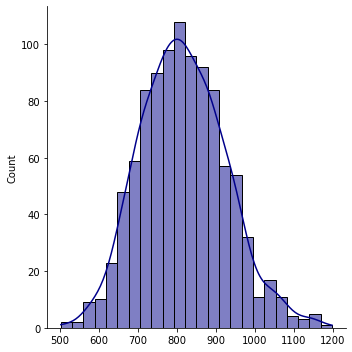

In [99]:
sns.displot(dtw_list, kde = True, color = 'darkblue',)